In [1]:
import pandas as pd  # Tabular data
from glob import glob  # File pattern matching
import os  # Operating System
import geopandas as gpd  # Geospatial data
import re  # Regular expressions
import math
from tqdm.auto import tqdm  # Progress bars
from tqdm.contrib.concurrent import thread_map, process_map  # Parallel operations
import rapidfuzz # Fuzzy string matching

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 130)

import platform
if platform.system() == "Windows":
  prefix = "Z:/"
else:
  prefix = "ressci201900060-RNC2-Coastal/"

df = pd.concat(pd.read_csv(f) for f in ["meta.csv", "LDS_meta.csv"])
# Filter to just shapefiles that have the CRS column defined
df = df[df.CPS & (df.n_lines > 0)]
df["Pixel_ER"] = (
    df.res.str.replace("(", "", regex=False).str.split(",").str[0].astype(float)
)
df = df[["filename", "matched_image", "Pixel_ER"]]
# Testing with BigBay
# df = df[df.filename.str.contains("BigBay")]
df

,filename,matched_image,Pixel_ER
0,MaxarImagery/HighFreq/HawkesBay/Mahanga/Shorelines/Mahanga_31AUG2005.shp,MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_31AUG2005.tif,0.600000
1,Retrolens/Tasman/MoutereRiver/Shorelines/MoutereRiver_19FEB2010.shp,MaxarImagery/HighFreq/Tasman/MoutereRiver/Imagery/Stack/MoutereRiver_19FEB2010.tif,0.600000
2,Retrolens/Tasman/MoutereRiver/Shorelines/MoutereRiver_31JAN1980.shp,Retrolens/Tasman/MoutereRiver/Stack/MoutereRiver_31JAN1980_mosaic.jp2,1.399795
3,Retrolens/Tasman/MoutereRiver/Shorelines/MoutereRiver_10AUG2003.shp,MaxarImagery/HighFreq/Tasman/MoutereRiver/Imagery/Stack/MoutereRiver_10AUG2003.tif,0.600000
4,Retrolens/Tasman/MoutereRiver/Shorelines/MoutereRiver_19APR2017.shp,MaxarImagery/HighFreq/Tasman/MoutereRiver/Imagery/Stack/MoutereRiver_19APR2017.tif,0.500000
...,...,...,...
51,Retrolens/Bay of Plenty/WaihiBeach/Shorelines/WaihiBeach_3DEC2014.shp,Retrolens/Bay of Plenty/WaihiBeach/Shorelines/WaihiBeach_3DEC2014.tif,0.125000
52,Retrolens/Bay of Plenty/PortOhope/Shorelines/OhopeBeach_3DEC2014.shp,Retrolens/Bay of Plenty/PortOhope/Shorelines/OhopeBeach_3DEC2014.tif,0.125000
53,Retrolens/Bay of Plenty/Ohiwa/Shorelines/Ohiwa_3DEC2014.shp,Retrolens/Bay of Plenty/Ohiwa/Shorelines/Ohiwa_3DEC2014.tif,0.125000
54,Retrolens/Bay of Plenty/PortOhope/Shorelines/OhopeBeach_3DEC2014.shp,Retrolens/Bay of Plenty/PortOhope/Shorelines/OhopeBeach_3DEC2014.tif,0.125000


Total UNCY:  
Total shoreline uncertainty (Et) is calculated as the root sum of squares of the pixel error (Ep), georeferencing error (Eg) and digitising error (Ed)  

$E_t = \sqrt{E_p^2 + E_g^2 + E_d^2}$

In [2]:
def get_scale(filename, DSASDate, year):
    # Find CSV for AOI
    bits = filename.split("/")
    terminator = min(
        bits.index("Stack") if "Stack" in bits else 1024,
        bits.index("Shorelines") if "Shorelines" in bits else 1024,
    )
    bits = bits[:terminator]
    csv_path_pattern = f"{prefix}{'/'.join(bits)}/*.csv"
    csv_candidates = glob(csv_path_pattern)
    if len(csv_candidates) == 0:
        print(f"No CSV found for {csv_path_pattern}")
    elif len(csv_candidates) > 1:
        print(f"Ambiguous CSVs: {csv_candidates}")
        csv_candidates = [csv_candidates[0]]
    assert len(csv_candidates) == 1
    csv_filename = csv_candidates[0]
    try:
        csv = pd.read_csv(csv_filename, encoding="cp1252")
    except UnicodeDecodeError:
        # Excel file saved with .csv extension
        print(f"{csv_filename} is actually an Excel file")
        csv = pd.read_excel(csv_filename)
        csv.Date = csv.Date.astype(str)
    if "RMSE" not in csv.columns:
        print(f"{csv_filename} has no RMSE column")
    

    # Fuzzy string match dates. Lots of typos.
    matched_date, score, index = rapidfuzz.process.extractOne(query=DSASDate, choices=csv.Date.unique())
    if score < 50:
        # Terrible match score, just use year
        matched_date, score, index = rapidfuzz.process.extractOne(query=year, choices=csv.Date.unique())
        print(f"Matching {year} to {matched_date} with score {score} for {csv_filename}")
    elif DSASDate != matched_date:
        print(f"Matching {DSASDate} to {matched_date} with score {score} for {csv_filename}")
    if "RMSE" in csv.columns:
        filtered_csv = csv[(csv.Date == matched_date) & ~csv.RMSE.isna()]
    else:
        filtered_csv = csv[(csv.Date == matched_date)]
    scales = filtered_csv.Scale.unique()
    if len(scales) == 0:
        print(f"No scales found for {csv_filename} for date {DSASDate}, removing RMSE filter")
        filtered_csv = csv[(csv.Date.str.contains(matched_date))]
        scales = filtered_csv.Scale.unique()
        print(f"Scales now: {scales}")
        if len(scales) == 0:
            print(f"Still no scales found for {csv_filename} for date {matched_date}, reducing date filter just to year from filename {year}")
            filtered_csv = csv[(csv.Date.str.contains(year))]
            scales = filtered_csv.Scale.unique()
            print(f"Scales now: {scales}")
    if len(scales) > 1:
        scales = filtered_csv.Scale.value_counts()
        print(f"Ambiguous scales found for {csv_candidates[0]} for date {DSASDate}: {scales}. Taking {scales.index[0]}")
        scales = [scales.index[0]]
    if len(scales) == 0:
        print(f"Can't find a scale for {filename}")
    assert len(scales) == 1
    return scales[0]


def get_Georef_ER(scale):
    if scale < 20000:
        return 2.09
    elif scale < 30000:
        return 2.43
    else:
        return 2.9


CPS_error_lookup = {1: 0.43, 2: 0.73, 3: 0.97, 4: 2.07, 5: 8.59}

def process_shapefile(tup):
    i,row=tup
    filename=row.filename
    year = re.search(r'(\d{4})', filename).group(1)
    shapefile = gpd.read_file(prefix + filename)
    if len(shapefile) == 0:
        print(f"{filename} is empty")
        return
    if "Source" not in shapefile.columns:
        print(f"{filename} has no Source")
        if filename.startswith("Retrolens"):
            source = "RL"
        elif filename.startswith("MaxarImagery/HighFreq"):
            source = "MAX"
        else:
            source = "Unknown"
    else:
        sources = shapefile.Source.unique()
        if len(sources) == 0 or not sources[0]:
            print(f"{filename} has no sources")
            if filename.startswith("MaxarImagery/HighFreq"):
                sources = ["MAX"]
            else:
                sources = ["Unknown"]
        if len(sources) > 1:
            print(f"{filename} has ambiguous sources: {sources}")
        source = sources[0]

    if source != "MAX" and filename.startswith("MaxarImagery"):
        print(f"{filename} doesn't have MAX source, overriding")
        source = "MAX"

    if source == "MAX":
        photoscale = pd.NA
        Georef_ER = 1.17
    elif source == "LDS":
        photoscale = pd.NA
        Georef_ER = 0
    else:
        if "DSASdate" in shapefile.columns:
            shapefile["DSASDate"] = shapefile.DSASdate
        dates = shapefile.DSASDate.unique()
        if len(dates) > 1:
            print(f"{filename} has ambiguous DSASDates: {dates}")
        if len(dates) == 0 or not dates[0]:
            print(f"{filename} has no DSASDate")
            DSASDate = year
        else:
            DSASDate = shapefile.DSASDate.unique()[0].lstrip("0")
        try:
            photoscale = get_scale(filename, DSASDate, year)
        except Exception as e:
            print(f"Got {e} when trying to get_scale for {filename}, {DSASDate}, {year}. Skipping")
            return
        Georef_ER = get_Georef_ER(photoscale)

    # Store inputs in shapefile
    shapefile["Photoscale"] = photoscale
    shapefile["Georef_ER"] = Georef_ER
    shapefile["Pixel_Er"] = row.Pixel_ER

    # Calculate Total_UNCY
    Ep = row.Pixel_ER
    Eg = Georef_ER
    for i, row in shapefile.iterrows():
        if row.CPS not in CPS_error_lookup:
            print(f"{row.CPS} not in CPS_error_lookup, skipping")
            continue
        Ed = CPS_error_lookup[row.CPS]
        Et = math.sqrt(Ep**2 + Eg**2 + Ed**2)
        shapefile.loc[i, "Total_UNCY"] = Et
    # display(shapefile)
    # To write results back to file:
    shapefile.to_file(prefix+filename)

thread_map(process_shapefile, df.iterrows(),_total=len(df))

9 not in CPS_error_lookup, skipping
Retrolens/Tasman/SandyBay/Shorelines/SandyBay_04May1944.shp is empty
9 not in CPS_error_lookup, skipping
Retrolens/Tasman/Totaranui/Shorelines/Totaranui_09APR1965.shp has ambiguous DSASDates: ['09/04/1965' '9/04/1965']
9 not in CPS_error_lookup, skipping


c:\Users\mtuc652\.conda\envs\coastsat\lib\site-packages\geopandas\array.py:150: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.from_shapely(data), crs=crs)


9 not in CPS_error_lookup, skipping
Retrolens/Tasman/MoutereRiver/Shorelines/MoutereRiver_13SEP1985.shp has ambiguous sources: ['RL' None]
Retrolens/Tasman/MoutereRiver/Shorelines/MoutereRiver_13SEP1985.shp has ambiguous DSASDates: ['13/09/1985' None]


c:\Users\mtuc652\.conda\envs\coastsat\lib\site-packages\geopandas\array.py:150: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.from_shapely(data), crs=crs)


Retrolens/Tasman/Totaranui/Shorelines/Totaranui_08FEB1952.shp has ambiguous DSASDates: ['08/02/1952' '8/02/1952']
Matching 1980 to 30/01/1980 with score 90.0 for Z:/Retrolens/Tasman/RuataniwhaInlet\RuataniwhaInlet.csv
Ambiguous scales found for Z:/Retrolens/Tasman/RuataniwhaInlet\RuataniwhaInlet.csv for date 11/10/1950: 17400    6
16700    1
Name: Scale, dtype: int64. Taking 17400
9 not in CPS_error_lookup, skipping
9 not in CPS_error_lookup, skipping
9 not in CPS_error_lookup, skipping
Retrolens/Canterbury/GoreBay/Shorelines/GoreBay_3NOV1965.shp is empty
9 not in CPS_error_lookup, skipping
9 not in CPS_error_lookup, skipping
9 not in CPS_error_lookup, skipping
Retrolens/Tasman/PoharaBeach/Shorelines/PoharaBeach_08FEB1952.shp has no sources
0 not in CPS_error_lookup, skipping
No scales found for Z:/Retrolens/Tasman/MoutereRiver\MoutereRiver.csv for date 19/05/1958, removing RMSE filter
Scales now: [44500]
Ambiguous CSVs: ['Z:/Retrolens/Tasman/PortPuponga\\PortPuponga.csv', 'Z:/Retrolen

In [ ]:
!./aggregate_shapefiles_to_geojson.py

./aggregate_shapefiles_to_geojson.py:26: TqdmWarning: Iterable length 1898 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  df = gpd.GeoDataFrame(pd.concat(process_map(read, df.filename))).to_crs(epsg=4326)
100%|███████████████████████████████████████| 1898/1898 [00:27<00:00, 70.08it/s]


In [ ]:
df = gpd.read_file("shorelines.geojson")
df.Total_UNCY.describe()

count    7542.000000
mean        2.949711
std         2.013223
min         0.441475
25%         1.599937
50%         2.452305
75%         3.241251
max         9.772838
Name: Total_UNCY, dtype: float64

In [ ]:
df

,Id,Region,Site,Date,DSASDate,Digitiser,Scale,Notes,Source,CPS,Proxy,Photoscale,Georef_ER,Pixel_Er,Total_UNCY,filename,Dig_ER,DATE_,DSASdate,Length,Date_,Scale_1,SN,DSASDate_1,DSASDate_2,UNCY,OBJECTID,SourceFile,Year_,Month_,Day_,Date2,Shape_Leng,Shape_Le_1,DSAS_NZDAT,geometry
0,0,HawkesBay,Mahanga,2005-08-31,31/08/2005,AF,1000,edge of veg,MAX,2,1,VHR,1.17,0.6,1.503928,MaxarImagery/HighFreq/HawkesBay/Mahanga/Shorelines/Mahanga_31AUG2005.shp,NaN,None,None,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,"LINESTRING (177.88792 -39.01518, 177.88782 -39.01512, 177.88775 -39.01510, 177.88768 -39.01509, 177.88761 -39.01507, 177.88753..."
1,0,HawkesBay,Mahanga,2005-08-31,31/08/2005,AF,1000,edge of veg,MAX,3,1,VHR,1.17,0.6,1.633952,MaxarImagery/HighFreq/HawkesBay/Mahanga/Shorelines/Mahanga_31AUG2005.shp,NaN,None,None,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,"LINESTRING (177.89780 -39.07104, 177.89791 -39.07116, 177.89799 -39.07149, 177.89800 -39.07161, 177.89804 -39.07179, 177.89810..."
2,0,HawkesBay,Mahanga,2011-01-29,29/01/2011,AF,1000,edge of veg,MAX,3,1,VHR,1.17,0.5,1.599937,MaxarImagery/HighFreq/HawkesBay/Mahanga/Shorelines/Mahanga_29JAN2011.shp,NaN,None,None,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,"LINESTRING (177.88811 -39.01504, 177.88800 -39.01505, 177.88785 -39.01505, 177.88774 -39.01504, 177.88760 -39.01498, 177.88755..."
3,0,HawkesBay,Mahanga,2011-01-29,29/01/2011,AF,1000,edge of veg,MAX,3,1,VHR,1.17,0.5,1.599937,MaxarImagery/HighFreq/HawkesBay/Mahanga/Shorelines/Mahanga_29JAN2011.shp,NaN,None,None,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,"LINESTRING (177.89765 -39.07099, 177.89784 -39.07114, 177.89787 -39.07121, 177.89792 -39.07134, 177.89795 -39.07147, 177.89797..."
4,0,HawkesBay,Mahanga,2015-12-25,25/12/2015,AF,1000,edge of veg,MAX,3,1,VHR,1.17,0.5,1.599937,MaxarImagery/HighFreq/HawkesBay/Mahanga/Shorelines/Mahanga_25DEC2015.shp,NaN,None,None,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,"LINESTRING (177.90875 -39.07788, 177.90871 -39.07785, 177.90865 -39.07782, 177.90864 -39.07779, 177.90859 -39.07776, 177.90861..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12480,0,Wellington,PukeruaBay,1980-09-20,20/09/1980,MD,1000,None,RLN,3,1,None,NaN,NaN,NaN,Retrolens/Wellington/PukeruaBay/Shorelines/PukeruaBay_20SEP1980.shp,NaN,None,None,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,"LINESTRING (174.90022 -41.02754, 174.90004 -41.02764, 174.89994 -41.02771, 174.89991 -41.02775, 174.89982 -41.02778, 174.89971..."
12481,0,Wellington,PukeruaBay,1980-09-20,20/09/1980,MD,1000,None,RLN,3,7,None,NaN,NaN,NaN,Retrolens/Wellington/PukeruaBay/Shorelines/PukeruaBay_20SEP1980.shp,NaN,None,None,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,"LINESTRING (174.89785 -41.02915, 174.89700 -41.02926, 174.89644 -41.02914, 174.89627 -41.02918, 174.89603 -41.02926, 174.89548..."
12482,0,Wellington,PukeruaBay,1980-09-20,20/09/1980,MD,1000,None,RLN,3,1,None,NaN,NaN,NaN,Retrolens/Wellington/PukeruaBay/Shorelines/PukeruaBay_20SEP1980.shp,NaN,None,None,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,"LINESTRING (174.89520 -41.02952, 174.89498 -41.02953, 174.89480 -41.02954, 174.89458 -41.02954, 174.89414 -41.02953, 174.89376..."
12483,0,Wellington,PukeruaBay,1980-09-20,20/09/1980,MD,1000,None,RLN,3,1,None,NaN,NaN,NaN,Retrolens/Wellington/PukeruaBay/Shorelines/PukeruaBay_20SEP1980.shp,NaN,None,None,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,"LINESTRING (174.88652 -41.02812, 174.88628 -41.02818, 174.88605 -41.02830, 174.88597 -41.02846, 174.88584 -41.02864, 174.88559..."


In [ ]:
df.Total_UNCY.isna().value_counts()

Total_UNCY
False    7542
True     4943
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

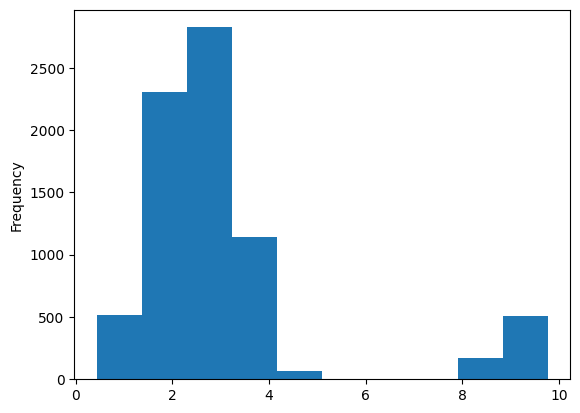

In [ ]:
df.Total_UNCY.plot.hist()

In [ ]:
df.groupby("filename").Total_UNCY.mean().sort_values(ascending=False).head(50)

filename
Retrolens/Nelson/BoulderBank/Shorelines/BoulderBank_06FEB1967.shp                                         9.665489
Retrolens/Tasman/MoutereSpit/Shorelines/MoutereSpit_04FEB1967.shp                                         9.644290
Retrolens/Southland/MasonsBay/Shorelines/MasonsBay_10DEC1958.shp                                          9.207819
Retrolens/HawkesBay/BayView/Shorelines/Bayview_17DEC1996.shp                                              9.177801
Retrolens/Tasman/MoutereSpit/Shorelines/MoutereSpit_31JAN1980.shp                                         9.174151
Retrolens/Bay of Plenty/PapateaBay/Shorelines/PapateaBay_31MAR1960.shp                                    9.172843
Retrolens/HawkesBay/Nuhaka/Shorelines/Nuhaka_16JAN2003.shp                                                9.137048
Retrolens/HawkesBay/WhakakiLagoon/Shorelines/WhakakiLagoon_16JAN2003.shp                                  9.136436
Retrolens/Wellington/OceanBeach/Shorelines/OceanBeach_16APR1995.shp    

In [ ]:
df.groupby("Source").Total_UNCY.mean().sort_values(ascending=False).head(50)

Source
RS     5.819791
RL     3.544775
RLN    3.534738
RLS    3.493485
AF     2.814997
MD     2.588462
Rl     2.265828
MAX    2.176943
Max    1.615922
LDS    1.008083
CRI         NaN
PLE         NaN
Name: Total_UNCY, dtype: float64

In [ ]:
df.Photoscale.value_counts()

Photoscale
VHR      3041
25000     725
16000     403
50000     319
17400     311
         ... 
45000       2
11600       2
18800       2
19600       1
18850       1
Name: count, Length: 79, dtype: int64

In [ ]:
df.Georef_ER.value_counts(dropna=False)

Georef_ER
NaN     4772
1.17    2768
2.09    1786
2.43    1766
2.90    1120
0.00     273
Name: count, dtype: int64

In [ ]:
df[(df.Source == "LDS") & ~df.Total_UNCY.isna()]

,Id,Region,Site,Date,DSASDate,Digitiser,Scale,Notes,Source,CPS,Proxy,Photoscale,Georef_ER,Pixel_Er,Total_UNCY,filename,Dig_ER,DATE_,DSASdate,Length,Date_,Scale_1,SN,DSASDate_1,DSASDate_2,UNCY,OBJECTID,SourceFile,Year_,Month_,Day_,Date2,Shape_Leng,Shape_Le_1,DSAS_NZDAT,geometry
4086,0,Hawkes Bay,MohakaRiver,2003-01-16,16/01/2003,AF,1000,stromberm and clifftoe,LDS,3,5,VHR,0.0,1.115226,1.478049,Retrolens/HawkesBay/MohakaRiver/Shorelines/MohakaRiver_16JAN2003.shp,NaN,None,None,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,"LINESTRING (177.19079 -39.12625, 177.19040 -39.12644, 177.19013 -39.12660, 177.18990 -39.12670, 177.18974 -39.12673, 177.18952..."
4087,0,Hawkes Bay,MohakaRiver,2003-01-16,16/01/2003,AF,1000,stromberm and clifftoe,LDS,3,5,VHR,0.0,1.115226,1.478049,Retrolens/HawkesBay/MohakaRiver/Shorelines/MohakaRiver_16JAN2003.shp,NaN,None,None,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,"LINESTRING (177.16877 -39.13387, 177.16869 -39.13397, 177.16845 -39.13407, 177.16825 -39.13411, 177.16807 -39.13418, 177.16771..."
4088,0,Hawkes Bay,MohakaRiver,2003-01-16,16/01/2003,AF,1000,stromberm and clifftoe,LDS,3,5,VHR,0.0,1.115226,1.478049,Retrolens/HawkesBay/MohakaRiver/Shorelines/MohakaRiver_16JAN2003.shp,NaN,None,None,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,"LINESTRING (177.12869 -39.14989, 177.12863 -39.14991, 177.12848 -39.14994, 177.12830 -39.15005, 177.12811 -39.15007, 177.12809..."
4089,0,Hawkes Bay,MohakaRiver,2003-01-16,16/01/2003,AF,1000,stromberm and clifftoe,LDS,3,5,VHR,0.0,1.115226,1.478049,Retrolens/HawkesBay/MohakaRiver/Shorelines/MohakaRiver_16JAN2003.shp,NaN,None,None,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,"LINESTRING (177.16164 -39.13646, 177.16156 -39.13654, 177.16141 -39.13660, 177.16133 -39.13665, 177.16122 -39.13671, 177.16110..."
4671,0,Southland,OretiBeachSouth,1974-02-17,17/02/1974,MT,1000,None,LDS,2,1,VHR,0.0,0.250000,0.771622,Retrolens/Southland/OretiBeachSouth/Shorelines/OreitBeachSouth_17FEB1974.shp,NaN,None,None,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,"LINESTRING (168.30496 -46.49104, 168.30456 -46.49115, 168.30424 -46.49141, 168.30396 -46.49171, 168.30379 -46.49198, 168.30357..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11507,0,Bay of Plenty,KohioawaBeach,2014-12-03,03/12/2014,ER,1000,None,LDS,3,1,VHR,0.0,0.125000,0.978021,Retrolens/Bay of Plenty/KohioawaBeach/Shorelines/KohioawaBeach_03DEC2014.shp,NaN,None,None,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,"LINESTRING (176.68613 -37.86367, 176.68598 -37.86372, 176.68585 -37.86373, 176.68569 -37.86363, 176.68557 -37.86357, 176.68535..."
11508,0,Bay of Plenty,KohioawaBeach,2014-12-03,03/12/2014,ER,1000,None,LDS,3,1,VHR,0.0,0.125000,0.978021,Retrolens/Bay of Plenty/KohioawaBeach/Shorelines/KohioawaBeach_03DEC2014.shp,NaN,None,None,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,"LINESTRING (176.66326 -37.85589, 176.66326 -37.85576, 176.66323 -37.85567, 176.66316 -37.85563, 176.66300 -37.85558, 176.66289..."
11509,0,Bay of Plenty,KohioawaBeach,2014-12-03,03/12/2014,ER,1000,None,LDS,3,1,VHR,0.0,0.125000,0.978021,Retrolens/Bay of Plenty/KohioawaBeach/Shorelines/KohioawaBeach_03DEC2014.shp,NaN,None,None,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,"LINESTRING (176.63391 -37.84447, 176.63391 -37.84427, 176.63380 -37.84414, 176.63355 -37.84396, 176.63326 -37.84379, 176.63295..."
11510,0,Bay of Plenty,KohioawaBeach,2014-12-03,03/12/2014,ER,1000,None,LDS,3,1,VHR,0.0,0.125000,0.978021,Retrolens/Bay of Plenty/KohioawaBeach/Shorelines/KohioawaBeach_03DEC2014.shp,NaN,None,None,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,"LINESTRING (176.60405 -37.83123, 176.60394 -37.83118, 176.60385 -37.83112, 176.6037

In [ ]:
Sample = gpd.read_file ("Z:/Retrolens/Tasman/MoutereRiver/Shorelines/MoutereRiver_13SEP1985.shp")
Sample

,Id,Region,Site,Date,DSASDate,Digitiser,Scale,Notes,Source,CPS,Proxy,Photoscale,Georef_ER,Pixel_Er,Total_UNCY,geometry
0,0,Tasman,MoutereRiver,1985-09-13,13/09/1985,MT,2000,Jacket Island,RL,2,1,25000,2.43,0.7342,2.641373,"LINESTRING (1603164.145 5443842.039, 1603165.468 5443825.502, 1603170.760 5443811.612, 1603182.005 5443801.028, 1603197.880 54..."
1,0,Tasman,MoutereRiver,1985-09-13,13/09/1985,MT,2000,Edge of Veg,RL,3,1,25000,2.43,0.7342,2.717508,"LINESTRING (1605037.395 5441385.040, 1605042.910 5441380.949, 1605056.404 5441366.926, 1605066.723 5441357.931, 1605074.925 54..."
2,0,None,None,1899-12-30,None,None,0,None,None,2,1,25000,2.43,0.7342,2.641373,"LINESTRING (1603036.783 5443606.602, 1603034.878 5443596.559, 1603037.259 5443589.019, 1603037.259 5443580.287, 1603040.037 54..."
3,0,Tasman,MoutereRiver,1985-09-13,13/09/1985,MT,2000,Jacket Island,RL,3,1,25000,2.43,0.7342,2.717508,"LINESTRING (1602221.433 5445643.789, 1602212.173 5445664.955, 1602205.955 5445685.593, 1602198.679 5445714.036, 1602193.387 54..."
4,0,Tasman,MoutereRiver,1985-09-13,13/09/1985,MT,2000,Edge of Veg,RL,4,1,25000,2.43,0.7342,3.275492,"LINESTRING (1603036.783 5443606.602, 1603042.339 5443620.361, 1603056.626 5443627.769, 1603074.883 5443628.034, 1603097.108 54..."


In [ ]:
Sample[Sample.Source.isna()].explore()